#A Pragmatic Introduction to Perceptual Vector Quantization (part 1)
###Luc Trudeau

## Context
This guide explains Perceptual Vector Quantization by presenting it in a practical context. By pratical, I mean that we will implement the Perceptual Vector Quantization in python right here in this notebook. The intended audience is mainly programmers, not necessarily python programmers, and the idea is that you can leverage your programming skills to better understand Perceptual Vector Quantization.

## Quantization

> What is quantization anyway?

Let's load up an image an give an example of quantization: 

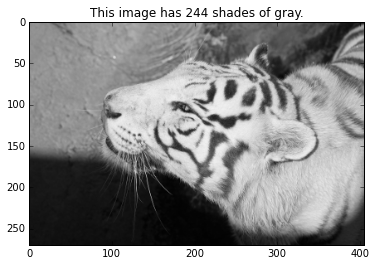

In [2]:
%matplotlib inline

import numpy as np
from scipy.ndimage  import imread
import matplotlib.pyplot as plt

def showImage(im):
    plt.imshow(im, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)
    plt.title("This image has %d shades of gray." % len(np.unique(im)))

im = imread("images/tiger.png")
im = im[:,:,1]
showImage(im)

**It's Quantizing time!** 

We will reduce the number of colors by a factor of 2. Each odd valued color will be replaced by the value of the even number right before it. For example, 43 becomes 42, we call this scalar quantization (scalar is just a fancy word for "_one number_"). 

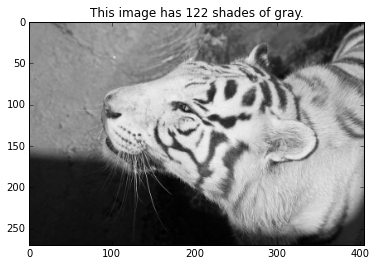

In [3]:
def quantize(im, step):
    return np.floor(im / step) * step

showImage(quantize(im, 2))

I guess if you look hard enough you can see the difference, but the truth is your eye is not really good a differentiating even and odd shades of gray. We can remove more shades of gray and see what quantization does

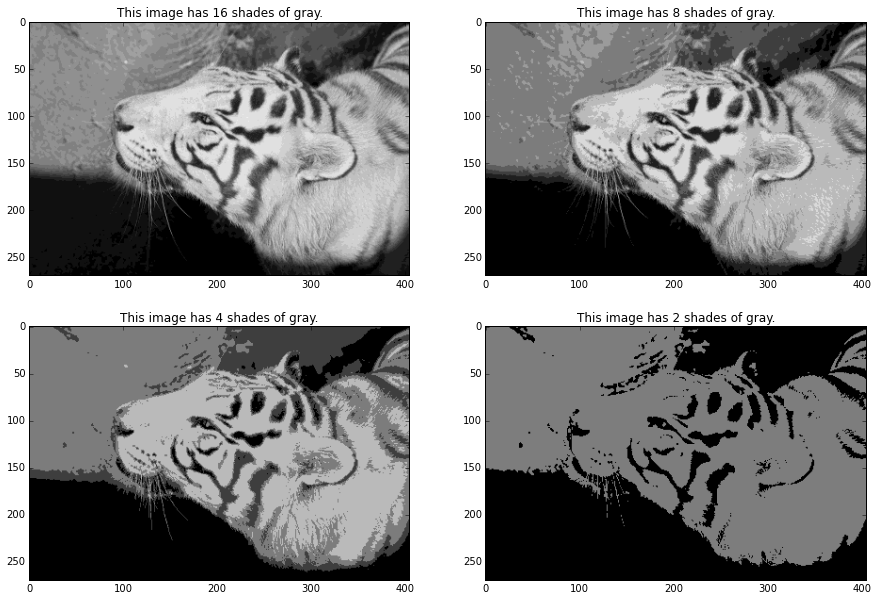

In [4]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
showImage(quantize(im, 16))
plt.subplot(2,2,2)
showImage(quantize(im, 31))
plt.subplot(2,2,3)
showImage(quantize(im, 62))
plt.subplot(2,2,4)
showImage(quantize(im, 125))

> Now I get Quantization! So let's "_perceptually vector quantize_" that tiger image!

Hold on there, turns out it's a lot more complicated, so we will keep that for part 2 in this series. For now, let's "_perceptually vector quantize_" something a little simpler, like this vector **v**: 

In [5]:
v = np.array([4,2])

Vector quantization is a fancy way of saying that we want to convert the whole vector into a single code. This code is called a codeword. The idea is that all the codewords are defined in a codebook. Before we present the codebook, let's start with the concepts of gain and shape, which will be needed to better understand how codewords work.

## Gain and Shape
To "_perceptually vector quantize_" **v**, we must first compute the norm of **v**:

In [6]:
def gain(v):
    return np.sqrt(np.dot(v,v))
print("Norm (aka gain) of v = %f" % (gain(v)))

Norm (aka gain) of v = 4.472136


As you noticed, we refer to the norm of **v** as the gain of **v**, which represents the amount of energy in the **v** (_I know there's a norm function in numpy, but doing it this way shows you why the gain measures energy_).



The next thing we need is the unit vector of **v**:

In [7]:
def shape(v):
    return np.true_divide(v, gain(v))
print("Unit vector (aka shape): %s" % (shape(v)))

Unit vector (aka shape): [ 0.89442719  0.4472136 ]


We refer to the unit vector of **v** as the shape of **v**. As its name suggest, the values of this vector show the shape of the energy distribution of **v**. The **shape** vector is in the same direction as **v** but is squaled to unit length. 

We can get back **v** from **shape** like so:

In [8]:
print("v = %s" % (shape(v) * gain(v)))

v = [ 4.  2.]


Instead of "_perceptually vector quantizing_" **v**, we will "_perceptually vector quantize_" **shape** and "_scalar quantize_" **gain**.

>Wait a second, this requires "_perceptually vector quantizing_" 4 values, plus "_scalar quantizing_" the gain. How is this better than just "_perceptually vector quantizing_" the 4 values of **v**? 

![](images/consider.jpg)

In [9]:
v2 = [2,1]
print("Gain of v2 = %s" % (gain(v2)))
print("Shape of v2 = %s" % (shape(v2)))

Gain of v2 = 2.2360679775
Shape of v2 = [ 0.89442719  0.4472136 ]


In [10]:
assert(shape(v).all() == shape(v2).all())

By using the shape of the **v** instead of the **v** itself, all vectors with the same shape will have the same codeword. Vectors with the same shape, are vectors that point in the same direction. In other words all different scales of the same vector. There's more to it than that, but for now let's focus on building the codebook.

## Building the codebook
You might have imagined the codebook as a big book of codes, each code cherry picked by an engineer for optimal performance. This is not that type of codebook, basically a simple equation is used to generate all possible values. The equation is: The sum of absolute values of the codeword must sum to **k**.

Just for fun (because we **won't** need it later) let's build the codebook. This is probably not the fastest way to build the codebook, but it should be easy to understand. We have 2 nested loops because we have 2 elements in **v**. Since the absolute value operator is used, valid values range from -**k** to **k**.

Codebook for k=2: 
[[-2  0]
 [-1 -1]
 [-1  1]
 [ 0 -2]
 [ 0  2]
 [ 1 -1]
 [ 1  1]
 [ 2  0]]


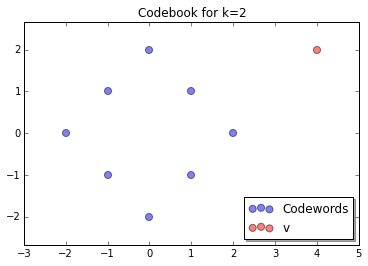

In [13]:
k = 2

def build2DCodeBook(k):
    codebook = []
    for x0 in range(-k,k+1):
        for x1 in range(-k,k+1):
            if abs(x0) + abs(x1) == k:
                codebook.append([x0, x1])
    return np.array(codebook)

def showCodeBook(codebook, k):
    plt.scatter(codebook[:][:,0], codebook[:][:,1], c="blue", label="Codewords", alpha=0.5, s=50)
    plt.scatter(v[0], v[1], c="red", label="v", alpha=0.5, s=50)
    plt.title("Codebook for k=%d" % (k))
    plt.legend(loc='lower right', shadow=True)
    plt.axis('equal')

codebook = build2DCodeBook(k)

print("Codebook for k=%d: \n%s" %(k,codebook))

showCodeBook(codebook, 2)

Geometrically, we notice that the codewords form a diamond shape, where the edges are at values of **k** in one axis. When we perform vector quantization, we chose a the code word closest to **v** as the codeword representing **v**. The distance between the codeword and **v** is the error.

Let's examine some other codeboooks

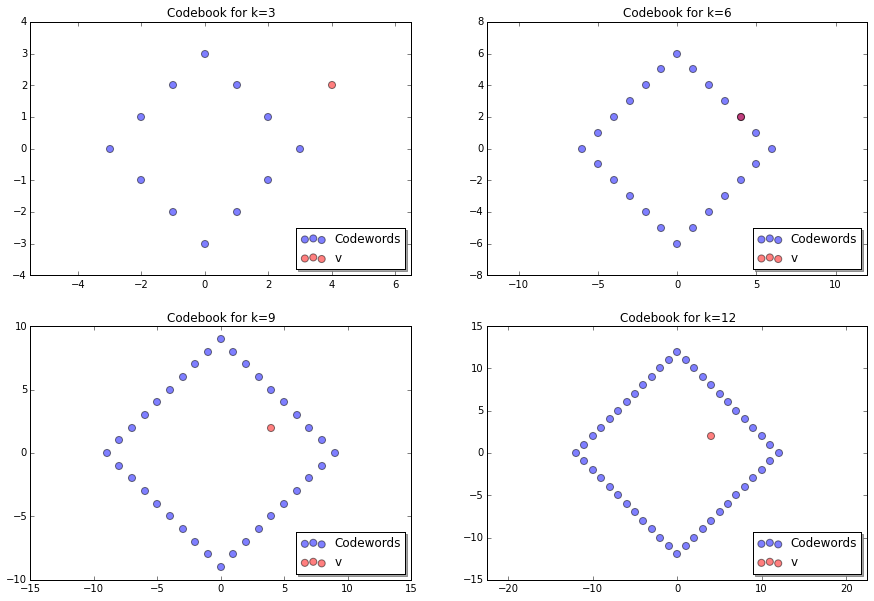

In [14]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
showCodeBook(build2DCodeBook(3), 3)

plt.subplot(2,2,2)
showCodeBook(build2DCodeBook(6), 6)

plt.subplot(2,2,3)
showCodeBook(build2DCodeBook(9), 9)

plt.subplot(2,2,4)
showCodeBook(build2DCodeBook(12), 12)

Notice that when **k**=6, **v** is actually a codeword, because the absolute value of the elements of v sum to 6. In this case, there is no quantization error. Also notice that when **k** is greater than 6, there's also error.

I displayed these codebooks because the integer values make it more intuitive, but remember that we are "_perceptually vector quantize_" **shape** not **v**, so we need to normalize our codebook, like so:

Normalized Codebook for k=2: 
[[-1.          0.        ]
 [-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]
 [ 0.         -1.        ]
 [ 0.          1.        ]
 [ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]
 [ 1.          0.        ]]


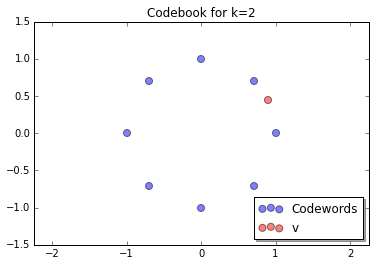

In [17]:
def shapeCodeBook(codebook):
    shapedCodeBook = []
    for codeword in codebook:
        shapedCodeBook.append(shape(codeword))
    return np.array(shapedCodeBook)

def showShapedCodeBook(codebook, k):
    plt.scatter(codebook[:][:,0], codebook[:][:,1], c="blue", label="Codewords", alpha=0.5, s=50)
    sh = shape(v)
    plt.scatter(sh[0], sh[1], c="red", label="v", alpha=0.5, s=50)
    plt.title("Codebook for k=%d" % (k))
    plt.legend(loc='lower right', shadow=True)
    plt.axis('equal')

shapedCodeBook = shapeCodeBook(codebook)
print("Normalized Codebook for k=%d: \n%s" %(k,shapedCodeBook))
showShapedCodeBook(shapedCodeBook, 2)

> Woah! normalizing changed the shape looks like a circle.

Yes, and it's no ordinary circle it's a [unit circle](https://en.wikipedia.org/wiki/Unit_circle) (_I admit that's just a fancy word for a circle of radius 1_)

Let's look at what happens when we increase k:

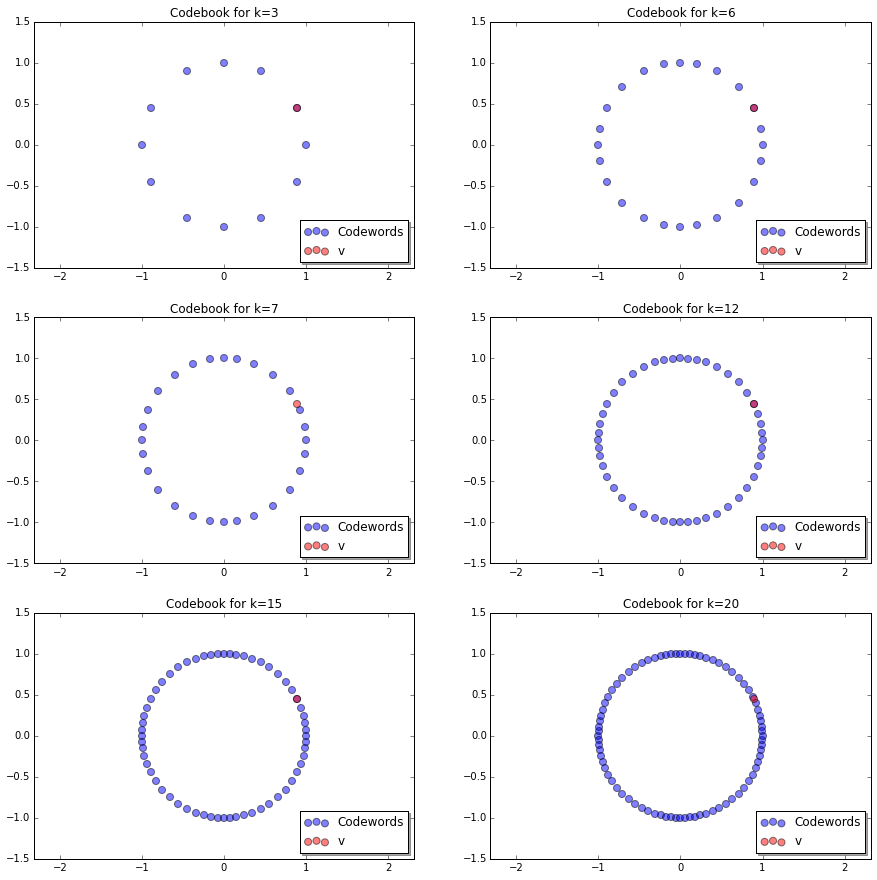

In [18]:
plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
showShapedCodeBook(shapeCodeBook(build2DCodeBook(3)), 3)

plt.subplot(3,2,2)
showShapedCodeBook(shapeCodeBook(build2DCodeBook(6)), 6)

plt.subplot(3,2,3)
showShapedCodeBook(shapeCodeBook(build2DCodeBook(7)), 7)

plt.subplot(3,2,4)
showShapedCodeBook(shapeCodeBook(build2DCodeBook(12)), 12)

plt.subplot(3,2,5)
showShapedCodeBook(shapeCodeBook(build2DCodeBook(15)), 15)

plt.subplot(3,2,6)
showShapedCodeBook(shapeCodeBook(build2DCodeBook(20)), 20)

Notice now, that by normalizing when **k** is a factor of 3 **v** is a valid code. Remember that example we did with v2? The absolute sum of its element is 3, and 3 is the smallest absolute sum of the shape of **v**.

**Spoiler Alert:** Also notice how the dots are distributed over the circle. They concentrate near the axis. This indicates the we have less precision when code uniform vectors. The reason I mention this is that in part 2, we will use the DCT to decorolate the vectors so they will not be uniform.

##Finding the code

> Aren't we suppose to "_vector quantize_" something at some point?

Almost there, we just need to specify a value for **k**. The "_vector quantize_" value of **v** depends on **k**. For this example, let's continue with **k** = 2.

A nice feature of our codebook is **that we don't need it** (best feature ever). We know the rule: the sum of the absolute values of the elements of the codeword must be equal to **k**. We don't need the codebook, all we can do is to find the smallest change to **v** so that sum of the absolute value of its elemens is **k**.

One way of doing this is to spread **k** over the distribution and round it out. If the sum of the absolute values is not **k**, we step closer to **k** with every iteration. 

In [133]:
import sys

def findCode(v, k):
    _shape = shape(v)

    # Here we spread k of the shape. Without rounding it sums to k, but the elements of the codeword must be integers
    codeword = np.round(_shape/sum(np.abs(_shape))*k)
    sa = sum(np.abs(codeword))
    
    if sa != k:
        step = np.sign(k - sa)
        while sa != k:
            minsse = sys.maxsize
            for i in range(0,2): # Iteratively apply step to every element and keep the best.
                codeword[i] = codeword[i] + step 
                sse = sum((_shape - shape(codeword))**2)
            
                if sse < minsse:
                    bestI = i
                    minsse = sse
                    
                codeword[i] = codeword[i] - step #Undo the step   
            
            codeword[bestI] = codeword[bestI] + step # Perform best step
            sa = sa + step

    return codeword
        
print("Perceptual Vector Quantization of v = %s " % (shape(findCode(v,2))))

Perceptual Vector Quantization of v = [ 0.70710678  0.70710678] 


##We did it!
We "_perceptually vector quantized_" **v**! You can check the codeword is in the codebook.

The burning question now is: "how good is our quantization of **v**?". Let's find out: 

In [132]:
def computeError(codeword, v):
    recon = shape(codeword) * gain(v)
    print("Reconstructed v = %s" % (recon))
    print("Sum of Absolute Difference: %f" % (sum(abs(recon - v))))
    print("Sum of Squared Error: %f" % (sum((recon - v)**2)))

computeError(findCode(v,2), v)

Reconstructed v = [ 3.16227766  3.16227766]
Sum of Absolute Difference: 2.000000
Sum of Squared Error: 2.052668


Yikes! That's far from **v**.

## Increasing k
We already know what happens when we increase k. If k = 3 the codeword should be a perfect match, let's try it out: 

In [136]:
computeError(findCode(v,3), v)

Reconstructed v = [ 4.  2.]
Sum of Absolute Difference: 0.000000
Sum of Squared Error: 0.000000


By adding more codes to our codebook, we decrease the error. Let's draw a plot to better understand what happens to the error when we increase k.

k = 2 Reconstructed Codeword = [ 3.16227766  3.16227766]
k = 3 Reconstructed Codeword = [ 4.  2.]
k = 4 Reconstructed Codeword = [ 4.24264069  1.41421356]
k = 5 Reconstructed Codeword = [ 3.72104204  2.48069469]
k = 6 Reconstructed Codeword = [ 4.  2.]
k = 7 Reconstructed Codeword = [ 4.15227399  1.6609096 ]
k = 8 Reconstructed Codeword = [ 3.83482494  2.30089497]
k = 9 Reconstructed Codeword = [ 4.  2.]
k = 10 Reconstructed Codeword = [ 4.11054154  1.76166066]
k = 11 Reconstructed Codeword = [ 3.88290137  2.21880078]
k = 12 Reconstructed Codeword = [ 4.  2.]
k = 13 Reconstructed Codeword = [ 4.08668948  1.81630644]
k = 14 Reconstructed Codeword = [ 3.90935018  2.17186121]
k = 15 Reconstructed Codeword = [ 4.  2.]
k = 16 Reconstructed Codeword = [ 4.07128266  1.85058303]
k = 17 Reconstructed Codeword = [ 3.92606836  2.14149183]
k = 18 Reconstructed Codeword = [ 4.  2.]
k = 19 Reconstructed Codeword = [ 4.06051781  1.87408514]


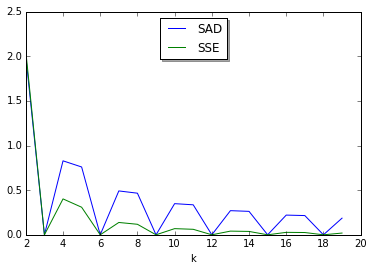

In [149]:
sad = []
sse = []
numKs = 20

for k in range(2,numKs):
    recon = shape(findCode(v,k)) * gain(v)
    print("k = %d Reconstructed Codeword = %s" % (k, recon))
    sad.append(sum(abs(recon - v)))
    sse.append(sum((recon - v)**2))

plt.plot(range(2,numKs), sad, label='SAD', c="orange")
plt.plot(range(2,numKs), sse, label='SSE', c="red")
plt.xlabel("k")
legend = plt.legend(loc='upper center', shadow=True)

Every time **k** is a factor of 3, we have zero error. Also notice that, as **k** increases, the error tends to decreases. This is what we expected, because when we increase **k** we increase the resolution accross our circle, so the distance with **v** must decrease. 

#Conclusion
So there you have it, as promised we "_perceptually vector quantized_" something. As we have seen, vector quantization involves finding (or computing) a codeword for a given vector. Perceptual vector quantization uses a codebook made up of all the codewords where the sum of the absolute values of their elements is **k**. You get to pick and chose **k**, a low value of **k** will result in a small codebook and little precision. Increasing the value of **k** improves the precision (up to a certain point).

**Let me know what you want to see in part 2 (Twitter @LT_Pragmatic).**

# Further reading
This work is based on:
 * The [Perceptual Vector Quantization demo](https://people.xiph.org/~jm/daala/pvq_demo/)
 * The paper [Perceptual Vector Quantization for Video Coding](http://jmvalin.ca/papers/spie_pvq.pdf) by Jean-Marc Valin and Timothy B. Terriberry
 * The paper [￼A Pyramid Vector Quantizer](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=1057198) by Thomas R. Fischer